## Redshift range matching estimation

Filter LSST data to certain r first observed magntiude range, and plot the redshift distribution of the resulting data versus original LSST and versus THEx

In [1]:
# Estimated counts per year 
LSST_counts = {"TDE" : 6000,
              "Ia-91bg": 24000,
              "Ia": 200000,
              "II" : 100000}

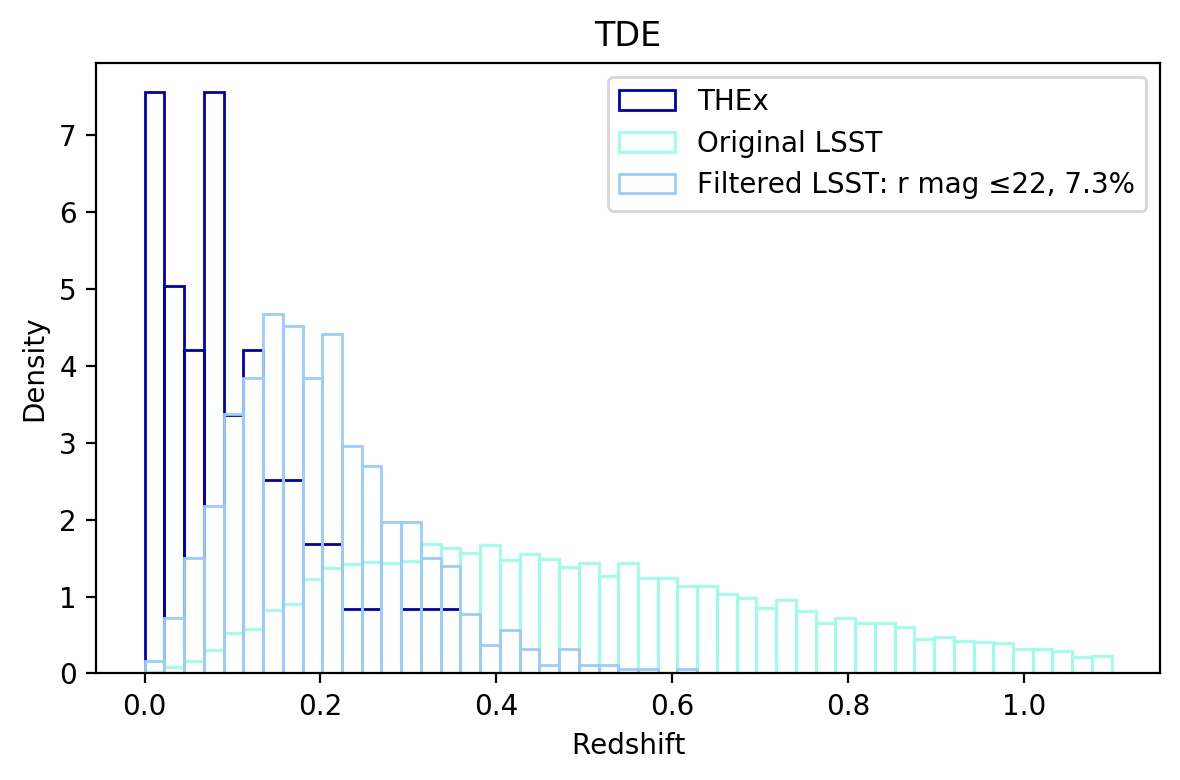

Estimated # of TDE from LSST [yr^-1] 438


In [3]:
from estimate.range_estimate import main
%matplotlib inline
# pass in [0, THEx class name, LSST class name, max r_mag val]
class_name = "TDE"
prop_kept=main([0, class_name, class_name, 22])
est_valid = int((prop_kept/100) * LSST_counts[class_name])
print("Estimated # of " + class_name + " from LSST [yr^-1] " + str(est_valid))




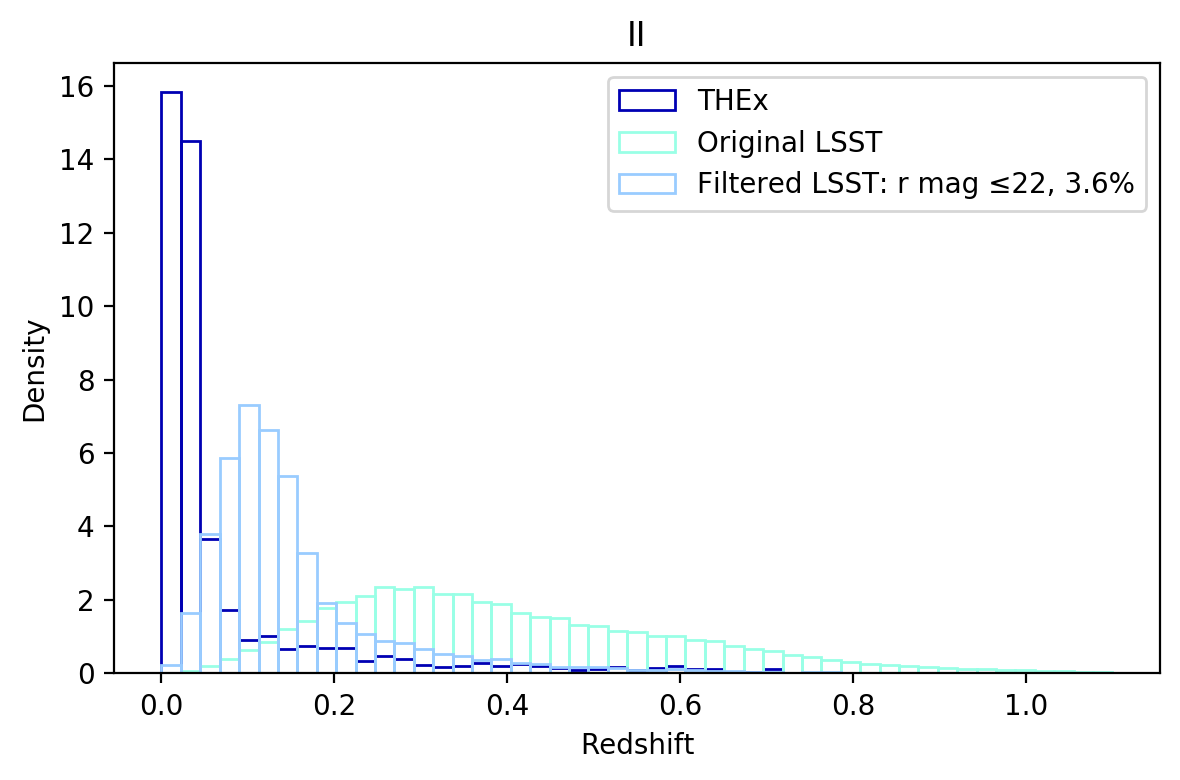

Estimated # of II from LSST [yr^-1] 3600


In [4]:
class_name = "II"
prop_kept=main([0, class_name, class_name, 22])
est_valid = int((prop_kept/100) * LSST_counts[class_name])
print("Estimated # of " + class_name + " from LSST [yr^-1] " + str(est_valid))



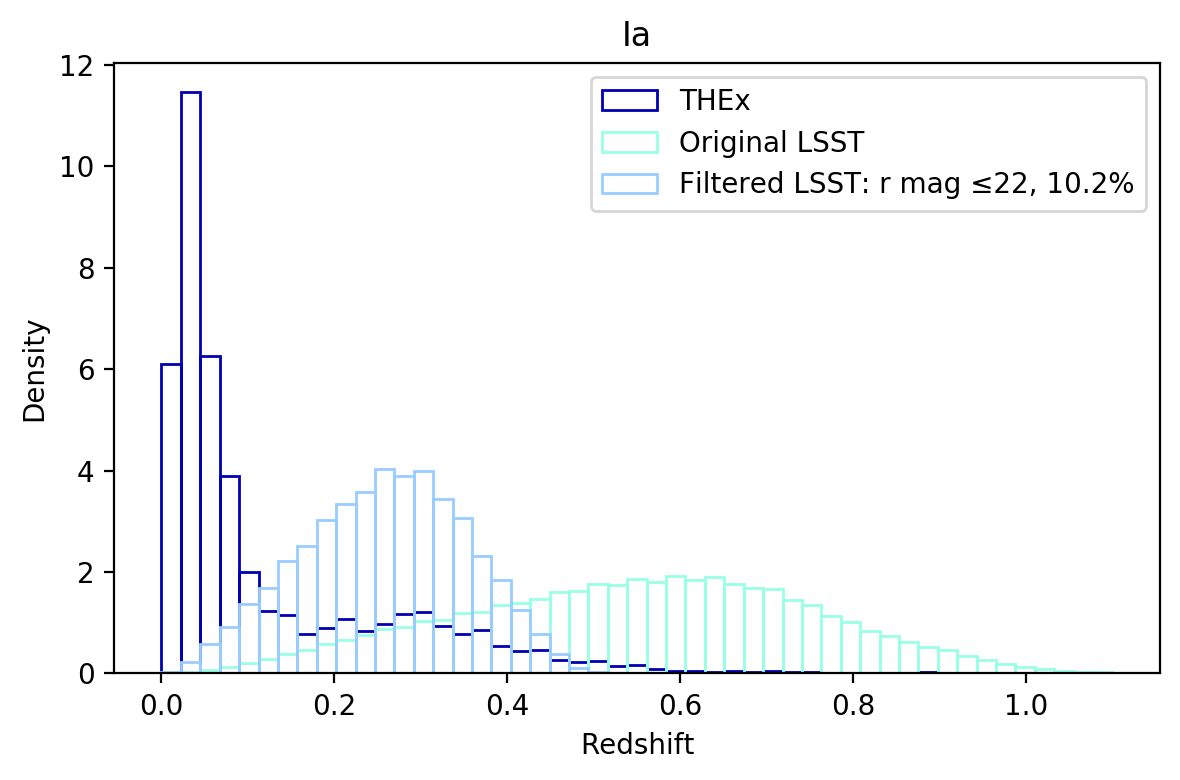

Estimated # of Ia from LSST [yr^-1] 20400


In [5]:
class_name = "Ia"
prop_kept=main([0, class_name, class_name, 22])
est_valid = int((prop_kept/100) * LSST_counts[class_name])
print("Estimated # of " + class_name + " from LSST [yr^-1] " + str(est_valid))



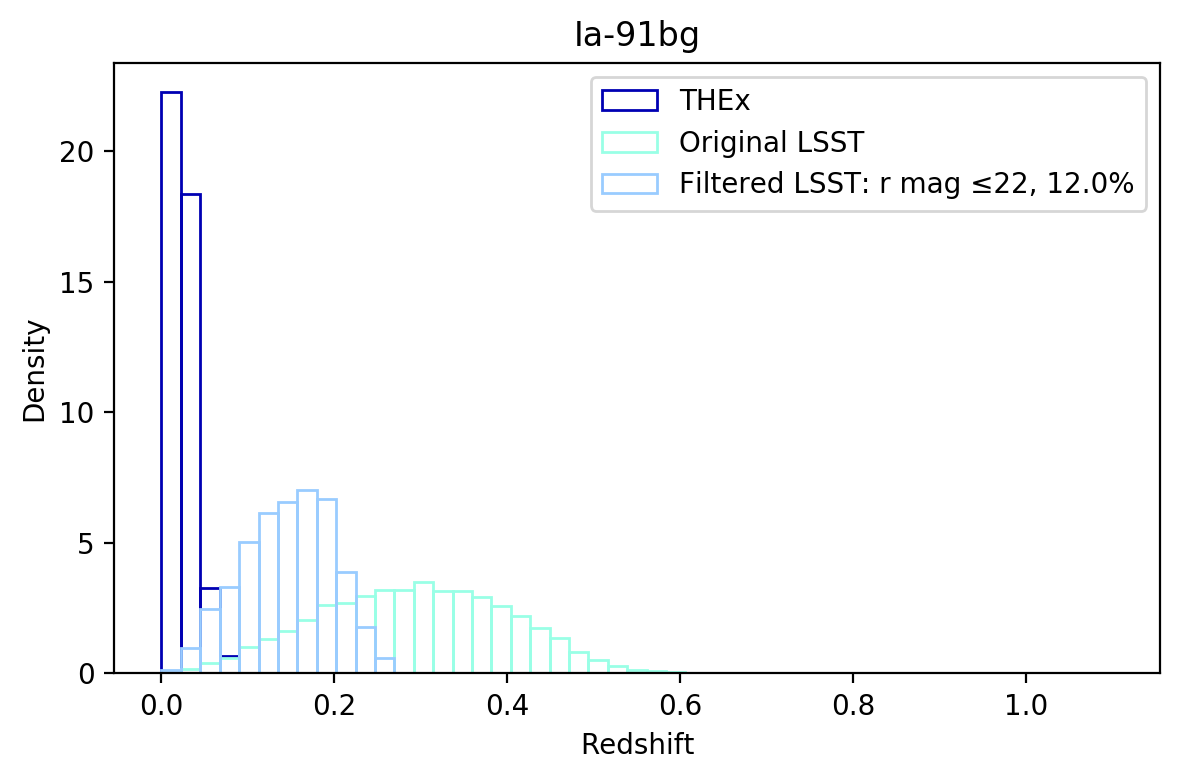

Estimated # of Ia-91bg from LSST [yr^-1] 2880


In [6]:

class_name = "Ia-91bg"
prop_kept=main([0, class_name, class_name, 22])
est_valid = int((prop_kept/100) * LSST_counts[class_name])
print("Estimated # of " + class_name + " from LSST [yr^-1] " + str(est_valid))




## Sample from dist

Sample from PLASTICCS distribution with same redshift frequency as present in our dataset. Then plot histogram of r_mag distributions to see if that tells us how we can cut them. Can plot that hist versus the real data hist.


In [56]:
L = lsst_Z_orig
T = thex_Z_gw2
Z_bins = np.linspace(0, 1.2, 50)
l, binsl = np.histogram(L, bins=Z_bins)
t, binst = np.histogram(T, bins=Z_bins)
t_length = len(T)
l_length = len(L)
t_freqs = t/t_length
l_freqs = l/l_length

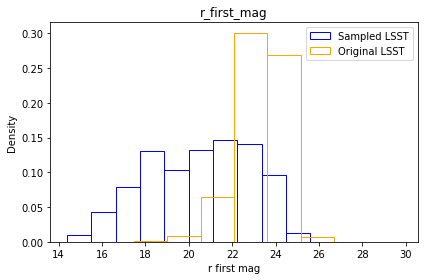

In [62]:
NUM_SAMPLES = 793
new_data = []
CLASS_NAME = "Ia"
FEATURE_NAME = "r_first_mag" # "r_first_mag"
data = get_lsst_class_data(CLASS_NAME, FEATURE_NAME, data=lc_prop)
for index, freq in enumerate(t_freqs):
    samples = NUM_SAMPLES * freq
    min_feature = Z_bins[index]
    max_feature = Z_bins[index+1]
    # Filter by redshift
    f_df = data[(data.iloc[:, 1] >= min_feature) & (data.iloc[:, 1] <= max_feature)]
    f_df = f_df.sample(n=int(samples))
    new_data.append(f_df)
    
df = pd.concat(new_data)
df = df.reset_index(drop=True)
fig, ax = plt.subplots(tight_layout=True,
                               sharex=True,
                               sharey=True
                            ) 
original_r_mags = data.iloc[:, 0]
ax.hist(df[FEATURE_NAME], density=True, label="Sampled LSST",  fill=False, edgecolor='blue')
ax.hist(original_r_mags, density=True, label="Original LSST",  fill=False, edgecolor='orange')
plt.title(FEATURE_NAME)
plt.legend()
plt.xlabel("r first mag")
plt.ylabel("Density")
plt.savefig("../figures/subsampled_lsst_"  + CLASS_NAME + "_"+ FEATURE_NAME + ".png")
plt.show()

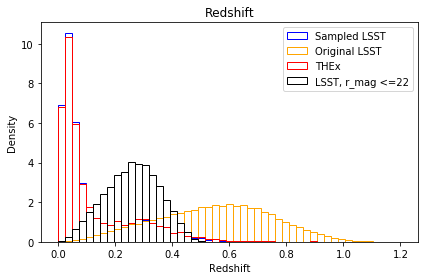

In [74]:
fig, ax = plt.subplots(tight_layout=True,
                               sharex=True,
                               sharey=True
                            ) 
original_Z = data.iloc[:, 1]
ax.hist(df['true_z'], bins=Z_bins, density=True, label="Sampled LSST",  fill=False, edgecolor='blue')
ax.hist(original_Z, bins = Z_bins, density=True, label="Original LSST",  fill=False, edgecolor='orange')
ax.hist(T, bins = Z_bins, density=True, label="THEx",  fill=False, edgecolor='red')

lsst_data_gw2 = get_LSST_filt_redshifts(min_feature=best_min_GW2,
                                        max_feature=22,
                                        data=LSST_data,
                                        r2=None) 

ax.hist(lsst_data_gw2, bins = Z_bins, density=True, label="LSST, r_mag <=22",  fill=False, edgecolor='black')

# lsst_data_gw2 = get_LSST_filt_redshifts(min_feature=best_min_GW2,
#                                         max_feature=19,
#                                         data=LSST_data,
#                                         r2=None) 

# ax.hist(lsst_data_gw2, bins = Z_bins, density=True, label="LSST, r_mag <=19",  fill=False, edgecolor='green')

plt.title("Redshift")
plt.xlabel("Redshift")
plt.ylabel("Density")
plt.legend()
plt.savefig("../figures/redshiftmatching.png")
plt.show()